<a href="https://colab.research.google.com/github/lucasbarretto/MNIST_GANN/blob/master/c-DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating MNIST dataset samples using Deep Convolutional GANs

# Setting up environment and loading the Dataset:

First, we define all the imports and define the device for the PyTorch framework.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# set device
device = torch.device("cuda")

Then, we load the MNIST Dataset. Note that the batch size is hard coded in the dataloader function parameter.

In [0]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

# Defining model architecture for D and G:

**Discriminator Network Architecture:**

4 layer convolutional neural network with leaky relu activation and sigmoid output.

Receives a 28x28 image and its respective label (integer between 0 and 9). The label is then embedded and resized to match the image and passed to the Network as a 2-channel 28x28 image.

The Network outputs the probability that the input image belongs to the real dataset.

In [0]:
class Discriminator(nn.Module):
    def __init__(self, d_n, n_classes):
        super(Discriminator, self).__init__()
        
        self.l1 = nn.Embedding(n_classes, 50)
        self.l2 = nn.Linear(50,28*28)

        self.conv1 = nn.Conv2d(2, d_n, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(d_n, d_n*2, 4, 2, 1, bias=False) 
        self.conv3 = nn.Conv2d(d_n*2, d_n*4, 4, 2, 1, bias=False) 
        self.conv4 = nn.Conv2d(d_n*4, 1, 3, 1, 0, bias=False)
        
    def forward(self, x, y):
        # embeds labels to 1 x 50
        y = self.l1(y)
        # linear layer converts embedded labels to 1 x 28 x 28
        y = self.l2(y)
        y = y.view(y.size(0),1,28,28)

        # concatenates image with embedded labels
        d_in = torch.cat((x,y), axis=1)

        # input is 2 x 28 x 28 
        d_in = F.leaky_relu(self.conv1(d_in), 0.2)
        # state size: d_n x 14 x 14
        d_in = F.leaky_relu(self.conv2(d_in), 0.2)
        # state size: (2*d_n) x 7 x 7
        d_in = F.leaky_relu(self.conv3(d_in), 0.2)
        # state size: (8*d_n) x 3 x 3
        d_in = torch.sigmoid(self.conv4(d_in))
        # state size: 1 x 1 x 1
        return d_in

**Generator Network Architecture:**

4 layer deconvolutional neural network with Leaky ReLU activation, BatchNorm and Hyperbolic Tangent output. Receives points from the latent space distribution and outputs a 28x28 image.

In [0]:
# define generator class
class Generator(nn.Module):
    def __init__(self, z_i, g_n):
        super(Generator, self).__init__()
        
        self.l1_y = nn.Embedding(n_classes, 50)
        self.l2_y = nn.Linear(50,10)

        self.l1_z = nn.Linear(z_i, 500)

        self.conv1 = nn.ConvTranspose2d(510, g_n*4, 3, 1, 0, bias=False)
        self.batchNorm1 = nn.BatchNorm2d(g_n*4)
        self.conv2 = nn.ConvTranspose2d(g_n*4, g_n*2, 3, 2, 0, bias=False)
        self.batchNorm2 = nn.BatchNorm2d(g_n*2)
        self.conv3 = nn.ConvTranspose2d(g_n*2, g_n, 2, 2, 0, bias=False)
        self.batchNorm3 = nn.BatchNorm2d(g_n)
        self.conv4 = nn.ConvTranspose2d(g_n, 1, 2, 2, 0, bias=False)

    def forward(self, z, y):
        # embeds labels to 1 x 50
        y = self.l1_y(y)

        # linear layer converts embedded labels to 1 x 100
        y = self.l2_y(y)
        
        # linear layer converts latent vector to 1 x 500
        z = self.l1_z(z)
        
        # concatenates latent vector with embedded labels
        g_in = torch.cat((z,y), axis=1)
        g_in = g_in.view(g_in.size(0), g_in.size(1), 1, 1)

        # input is 600 x 1 x 1
        g_in = F.leaky_relu(self.batchNorm1(self.conv1(g_in)), 0.2)
        # state size: (4*g_n) x 3 x 3
        g_in = F.leaky_relu(self.batchNorm2(self.conv2(g_in)), 0.2)
        # state size: (2*g_n) x 7 x 7
        g_in = F.leaky_relu(self.batchNorm3(self.conv3(g_in)), 0.2)
        # state size: (g_n) x 14 x 14
        g_in = torch.tanh(self.conv4(g_in))
        # state size: 1 x 28 x 28
        return g_in

# GAN helper functions:

**Generating points from the latent space distribution:**

The first function we will define is a function to generate points from the latent space distribution. In this case, we will generate a 100-dimension vector with points sampled from a normal distribution.

In [0]:
def generateLatentPoints(batch_size, z_i, n_classes):
    z = torch.randn((batch_size, z_i), device=device)
    y = torch.randint(n_classes, (batch_size,), device=device)
    return z, y

**Evaluating the model:**

These functions help us evaluate how the model is working by printing samples of generated images conditioned by labels from 1 to 9.

In [0]:
# function to evaluate model
def evaluateModel(G, z_i, n_classes):

    label = torch.arange(n_classes, device=device)
    
    z, _ = generateLatentPoints(n_classes, z_i, n_classes)

    # generate sample images
    G.eval()
    with torch.no_grad():
        images = G(z,label)
        
    return images

# function to evaluate a label condition
def evaluateCondition(G, z_i, n_classes, label):
    n_images = 9

    label = label*torch.ones((n_images,), device=device, dtype=torch.int64)
    z, _ = generateLatentPoints(n_images, z_i, n_classes)

    # generate sample images
    G.eval()
    with torch.no_grad():
        images = G(z,label)
        
    return images

**Generating labels:**

This function generates labels for the discriminator network. 

The simplest case consists of binary labels: 1 indicates that the image belongs to the real dataset and 0 indicates that the image does not belong to the original dataset.

Label smoothing can be added to introduce noise to the system, and therefore, labels are not binary, they are random numbers within a close range to the desired label. Example: true = [0.8,1.2] and false = [0, 0.3].

In [0]:
def generateLabels(arg, batch_size, smooth=False):
    
    random = torch.rand(batch_size, 1, 1, 1, device=device)
    ones = torch.ones(batch_size, 1, 1, 1, device=device)
    zeros = torch.zeros(batch_size, 1, 1, 1, device=device)
        
    # label smoothing is on
    if smooth:
        # true labels are in range [0.8, 1.2]
        if arg == 'True':
            labels = 1.2-0.4*random
        
        # false labels are in range [0.0, 0.3]
        if arg == 'False':
            labels = 0.2*random
    
    # label smoothing is off
    else:
        if arg == 'True':
            # true labels are 1s
            labels = ones
        if arg == 'False':
            # false labels are 0s
            labels = zeros
    
    return labels

**Initializing Weights:**

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.

In [0]:
def initWeights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Helper print functions:**

In [0]:
# function to print sample images
def printImages(images):
    for i in range(len(images)):
        ax = plt.subplot(1,len(images),i+1)
        ax.set_axis_off()
        ax = plt.imshow(images[i].view(28,28).cpu().numpy(), cmap='gray')
    plt.show()

# function to print multiple image lines
def printImageMatrix(imageData, title):
    numRows = len(imageData)
    
    n=0
    fig = plt.figure(1)
    fig.suptitle(title)
    for line in imageData:
        for i in range(len(line)):
            ax = fig.add_subplot(numRows,len(line),n+1)
            ax.set_axis_off()
            ax = plt.imshow(line[i].view(28,28).cpu().numpy(), cmap='gray')
            n+=1 
    plt.savefig('image:' + str(title) + '.png')
    plt.show()

# function to print model losses
def printLosses(d_loss, g_loss, save=False):
    plt.plot(d_loss, label='Discriminator Loss', c='blue')
    plt.plot(g_loss, label='Generator Loss', c='orange')
    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if save:
        plt.savefig('image:losses.png')
    plt.show()

# GAN training function:

This function trains both the generator and discriminator models

In [0]:
def train(z_i, max_epochs, n_classes):
    print('started training')
    
    criterion = nn.BCELoss()  # binary cross entropy loss

    # initialize data structures
    d_loss_data = []
    d_loss_avg = []
    g_loss_data = []
    g_loss_avg = []
    generatedImages = []

    # main training loop
    for epoch in range(max_epochs):

        for i,data in enumerate(trainloader,0):                
            realImages, real_y = data[0].to(device), data[1].to(device)
            batchSize = real_y.size(0)
            d_optimizer.zero_grad()
            
            # train D on real samples (RS = Real Samples)
            d_prediction_RS = D(realImages, real_y)
            d_labels_RS = generateLabels('True', batchSize, smooth=True) # samples belong to the real data
            d_loss_RS = criterion(d_prediction_RS, d_labels_RS) # D loss for real samples
            d_loss_RS.backward() # compute gradients without changing D's parameters
            
            # train D on fake samples (FS = Fake Samples)
            z, y = generateLatentPoints(batchSize, z_i, n_classes)
            fakeImages = G(z, y)
            d_prediction_FS = D(fakeImages, y)
            d_labels_FS = generateLabels('False', batchSize, smooth=True) # samples belong to the generated data
            d_loss_FS = criterion(d_prediction_FS, d_labels_FS) # D loss for fake samples
            d_loss_FS.backward() # compute gradients without changing D's parameters
        
            d_loss = d_loss_RS + d_loss_FS
            d_optimizer.step()

            # train G
            g_optimizer.zero_grad()
            z, y = generateLatentPoints(batchSize, z_i, n_classes)
            fakeImages = G(z, y)
            d_loss_g = D(fakeImages, y)
            d_labels_g = generateLabels('True', batchSize, smooth=True)
            g_loss = criterion(d_loss_g, d_labels_g)

            g_loss.backward()
            g_optimizer.step()
            
            # store losses for each iteration
            d_loss_data.append(d_loss.item())
            g_loss_data.append(g_loss.item())
            
        # print losses
        if epoch % 1 == 0:
            # print losses
            printLosses(d_loss_data, g_loss_data)
            
            # print losses for generator and discriminator
            print('Epoch: %s - D: (%s) | G: (%s)' % (epoch, d_loss.item(), g_loss.item()))

            # print samples of generated images through training
            sampleImages = evaluateModel(G, z_i, n_classes)
            generatedImages.append(sampleImages)
            printImages(sampleImages)

        # store avg epoch loss
        d_loss_avg.append(np.mean(d_loss_data))
        g_loss_avg.append(np.mean(g_loss_data))
    
    print('finished training')
    return d_loss_avg, g_loss_avg, generatedImages

# Creating, training and validating the models:

Here, we will create the models with the desired hyperparameters and define the respective optimizers.

In [0]:
# discriminator hyperparameters
d_n = 64 # discriminator feature maps size
n_classes = 10 # number of classes

# generator hyperparameters
z_i = 100 # random distribution input size
g_n = 64 # generator feature maps size

# initiate the discriminator network
D = Discriminator(d_n, n_classes).to(device)
D.apply(initWeights)

# initiate the generator network
G = Generator(z_i, g_n).to(device)
G.apply(initWeights)

# define optimizers
d_optimizer = optim.Adam(D.parameters(), lr = 0.0002, betas=(0.5,0.99))
g_optimizer = optim.Adam(G.parameters(), lr = 0.0002, betas=(0.5,0.99))

# training hyperparameters
maxEpochs = 20

Now, we can train both models through the adversarial framework.

started training


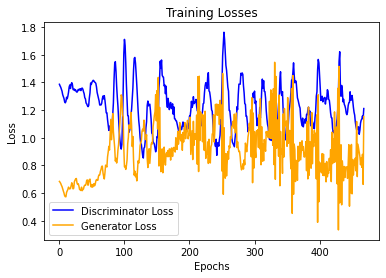

Epoch: 0 - D: (1.211111307144165) | G: (1.153969645500183)


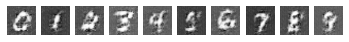

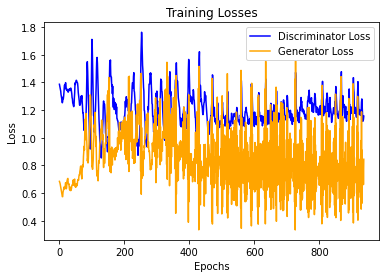

Epoch: 1 - D: (1.156200647354126) | G: (0.8443292379379272)


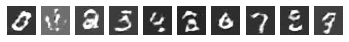

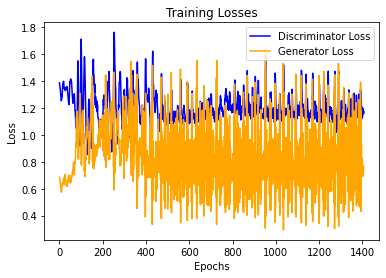

Epoch: 2 - D: (1.1717169284820557) | G: (0.7561964988708496)


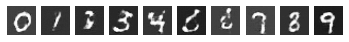

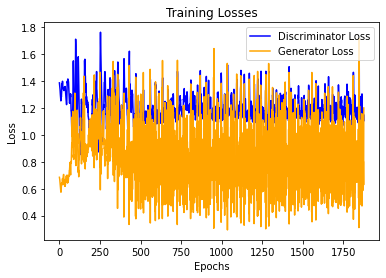

Epoch: 3 - D: (1.146442174911499) | G: (1.1999343633651733)


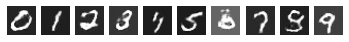

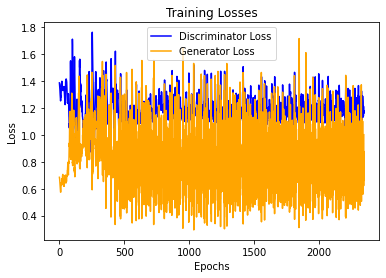

Epoch: 4 - D: (1.1778903007507324) | G: (1.0010876655578613)


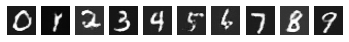

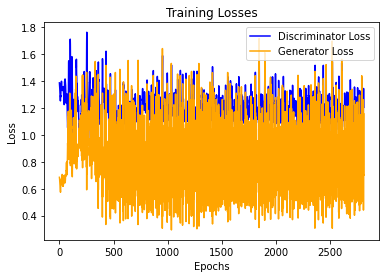

Epoch: 5 - D: (1.2045464515686035) | G: (0.7028524875640869)


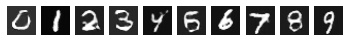

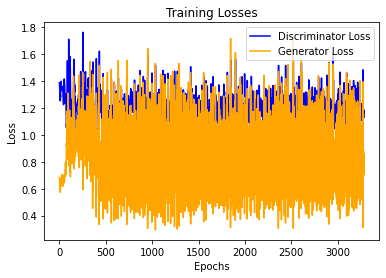

Epoch: 6 - D: (1.1817100048065186) | G: (0.8774771690368652)


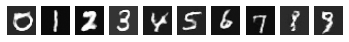

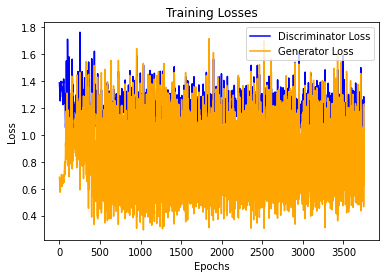

Epoch: 7 - D: (1.2403212785720825) | G: (0.62531578540802)


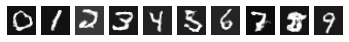

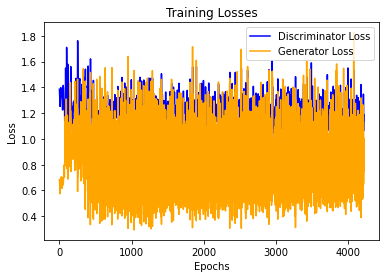

Epoch: 8 - D: (1.1886197328567505) | G: (0.7649752497673035)


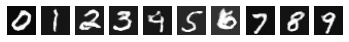

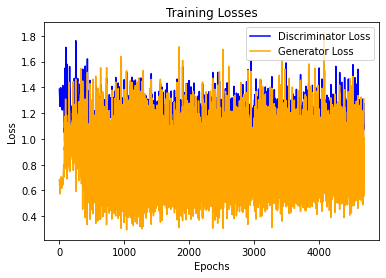

Epoch: 9 - D: (1.2730647325515747) | G: (1.3116382360458374)


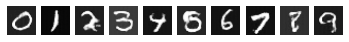

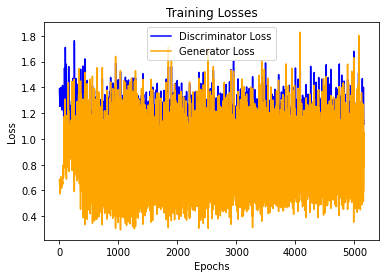

Epoch: 10 - D: (1.118380069732666) | G: (0.9140247106552124)


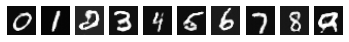

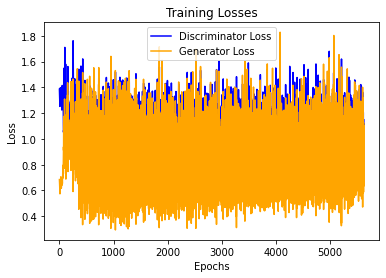

Epoch: 11 - D: (1.1485021114349365) | G: (0.5924452543258667)


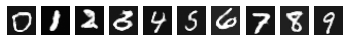

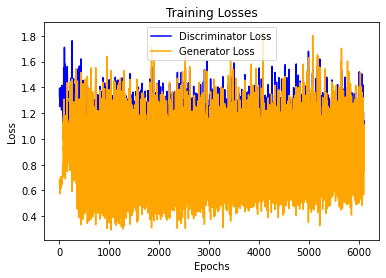

Epoch: 12 - D: (1.0712882280349731) | G: (0.5706028938293457)


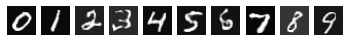

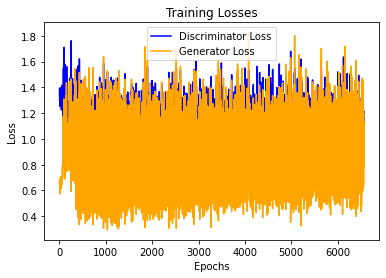

Epoch: 13 - D: (0.9161269068717957) | G: (0.798275351524353)


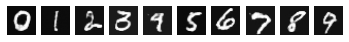

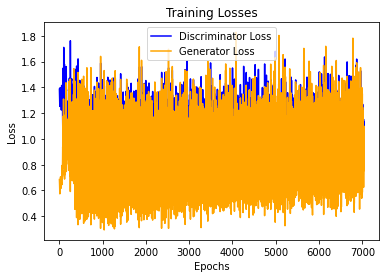

Epoch: 14 - D: (1.1303064823150635) | G: (0.9248132705688477)


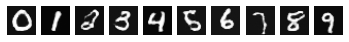

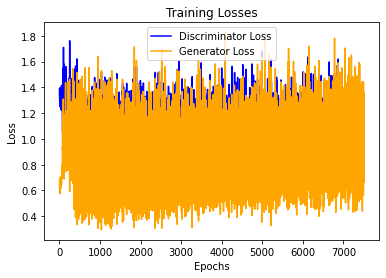

Epoch: 15 - D: (1.2024106979370117) | G: (1.354005217552185)


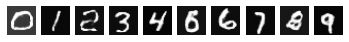

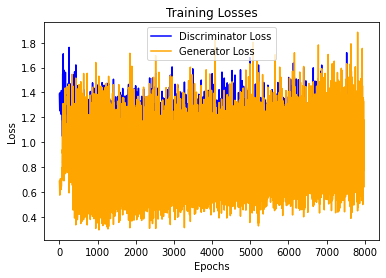

Epoch: 16 - D: (1.0635039806365967) | G: (0.8516019582748413)


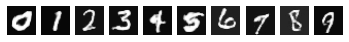

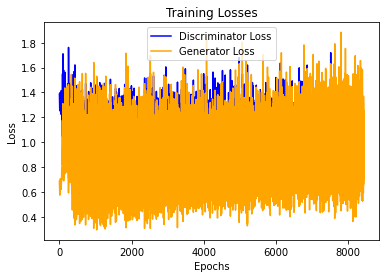

Epoch: 17 - D: (1.0682806968688965) | G: (1.254779577255249)


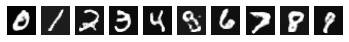

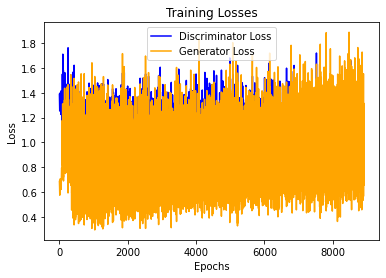

Epoch: 18 - D: (1.0659574270248413) | G: (0.7166265249252319)


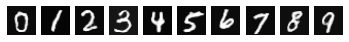

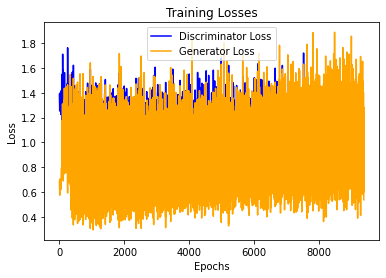

Epoch: 19 - D: (1.0374784469604492) | G: (0.5365833640098572)


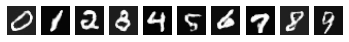

finished training


In [31]:
d_loss, g_loss, generatedImages = train(z_i, maxEpochs, n_classes)

After the training, we can print some results:

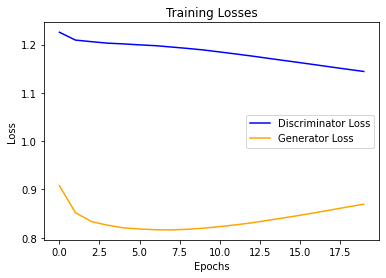

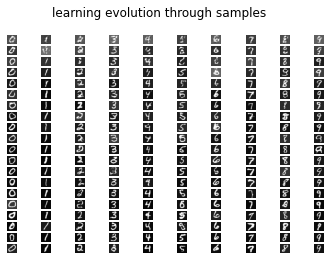

In [32]:
# print losses
printLosses(d_loss, g_loss, save=True)

# print learning evolution
printImageMatrix(generatedImages, 'learning evolution through samples')

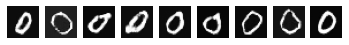

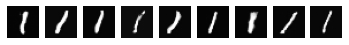

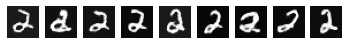

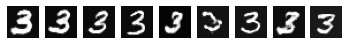

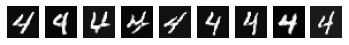

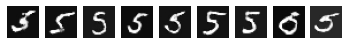

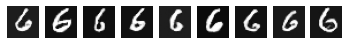

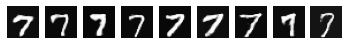

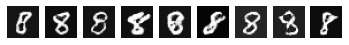

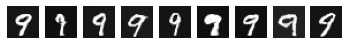

In [36]:
# print samples conditioned for all labels
for i in range(10):
    images = evaluateCondition(G, z_i, n_classes, label=i)
    printImages(images)

Save/load the trained models

In [34]:
# define the file name
PATH = 'G_model_c-CNN_' + str(maxEpochs) + 'epochs' + '.pt'

# save model state dict
torch.save(G.state_dict(), PATH)

# load trained model
Gtrained = Generator(z_i, g_n)
Gtrained.load_state_dict(torch.load(PATH))
Gtrained.to(device)

Generator(
  (l1_y): Embedding(10, 50)
  (l2_y): Linear(in_features=50, out_features=10, bias=True)
  (l1_z): Linear(in_features=100, out_features=500, bias=True)
  (conv1): ConvTranspose2d(510, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
)